### ***Step 4 Evaluation***

#### ***Preparation for new Notebook***

In [2]:
#Get basics for running notebook
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, average_precision_score,
    recall_score,
    mean_absolute_error, mean_squared_error, r2_score
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

N_COMPONENTS = 50


N_Components -> For exploratory analysis (Step 1), PCA with a small number of components was used to visualize global structure.
For prediction and evaluation (Steps 3–4), a larger number of components (50) was chosen to retain more information while still reducing dimensionality. As seen in scree-plot, 50 might be suitable as well!

In [12]:
#Order is missleading, but thematically attached to n_components - run build_eval_models first!
for n_comp in [5, 20, 50, 100]:
    models_tmp, scoring_tmp, cv_tmp = build_eval_models(
        task="binary",
        random_state=RANDOM_STATE,
        n_components=n_comp,
        best_k=best_k
    )
    pipe_tmp = models_tmp["LogReg"]
    scores = cross_val_score(
        pipe_tmp, X_train, y_train,
        cv=StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE),
        scoring="roc_auc"
    )
    print(f"PCA={n_comp}: ROC-AUC mean={scores.mean():.3f}")


PCA=5: ROC-AUC mean=0.904
PCA=20: ROC-AUC mean=0.893
PCA=50: ROC-AUC mean=0.927
PCA=100: ROC-AUC mean=0.930


In [13]:
# using 50! PCA
models, scoring, cv = build_eval_models(
    task="binary",
    random_state=RANDOM_STATE,
    n_components=N_COMPONENTS,  # 50
    best_k=best_k
)

pipe_lr = models["LogReg"]

assert pipe_lr.named_steps["pre"].named_steps["pca"].n_components == N_COMPONENTS


In [5]:
#Load an Merge Data

PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"

df_gex = pd.read_csv(DATA_DIR / "mammacarcinoma_gex.csv")
df_pat = pd.read_csv(DATA_DIR / "mammacarcinoma_pat.csv")

if "patient_id" not in df_gex.columns:
    raise ValueError("df_gex missing 'patient_id'")
if "patient_id" not in df_pat.columns:
    raise ValueError("df_pat missing 'patient_id'")

df = df_pat.merge(df_gex, on="patient_id", how="inner")
print("Merged df shape:", df.shape)

gene_cols = [c for c in df_gex.columns if c != "patient_id"]
print("Number of gene features:", len(gene_cols))
# rerun than ok

Merged df shape: (327, 6391)
Number of gene features: 6384


In [6]:
#Build feature Matrix again

def make_xy_for_target(df_merged, gene_cols, target):
    df_t = df_merged.dropna(subset=[target]).copy()
    X = df_t[gene_cols].copy()
    y = df_t[target].copy()

    X.index = df_t["patient_id"].values
    y.index = df_t["patient_id"].values
    return X, y


In [14]:
#Models, need to be reloaded for a new jupyter notebook. 

def make_preprocess(n_components=50, random_state=42):
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=n_components, random_state=random_state))
    ])

# choose best_k from previous work (if unknown, set to 11)
best_k = 11

def build_eval_models(task, random_state=42, n_components=50, best_k=11):
    pre = make_preprocess(n_components=n_components, random_state=random_state)
    

    if task == "binary":
        models = {
            "LogReg": Pipeline([
                ("pre", pre),
                ("model", LogisticRegression(
                    solver="lbfgs",
                    max_iter=5000,
                    class_weight="balanced",
                    random_state=random_state
                ))
            ]),
            "RF": Pipeline([
                ("pre", pre),
                ("model", RandomForestClassifier(
                    n_estimators=500,
                    class_weight="balanced_subsample",
                    random_state=random_state,
                    n_jobs=-1
                ))
            ]),
            f"kNN(k={best_k})": Pipeline([
                ("pre", pre),
                ("model", KNeighborsClassifier(
                    n_neighbors=best_k,
                    weights="distance"
                ))
            ]),
            "Dummy(most_frequent)": Pipeline([
                ("pre", pre),
                ("model", DummyClassifier(
                    strategy="most_frequent",
                    random_state=random_state
                ))
            ])
        }

        scoring = {
            "roc_auc": "roc_auc",
            "avg_precision": "average_precision",
            "balanced_acc": "balanced_accuracy",
            "f1": "f1"
        }

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        return models, scoring, cv

    if task == "multiclass":
        models = {
            "LogReg": Pipeline([
                ("pre", pre),
                ("model", LogisticRegression(
                    solver="lbfgs",
                    max_iter=5000,
                    class_weight="balanced",
                    random_state=random_state
                ))
            ]),
            "RF": Pipeline([
                ("pre", pre),
                ("model", RandomForestClassifier(
                    n_estimators=500,
                    class_weight="balanced_subsample",
                    random_state=random_state,
                    n_jobs=-1
                ))
            ]),
            f"kNN(k={best_k})": Pipeline([
                ("pre", pre),
                ("model", KNeighborsClassifier(
                    n_neighbors=best_k,
                    weights="distance"
                ))
            ]),
            "Dummy(most_frequent)": Pipeline([
                ("pre", pre),
                ("model", DummyClassifier(
                    strategy="most_frequent",
                    random_state=random_state
                ))
            ])
        }

        scoring = {
            "balanced_acc": "balanced_accuracy",
            "macro_f1": "f1_macro",
            "accuracy": "accuracy"
        }

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        return models, scoring, cv

    if task == "regression":
        models = {
            "Ridge": Pipeline([
                ("pre", pre),
                ("model", Ridge())
            ]),
            "RFReg": Pipeline([
                ("pre", pre),
                ("model", RandomForestRegressor(
                    n_estimators=500,
                    random_state=random_state,
                    n_jobs=-1
                ))
            ]),
            "Dummy(mean)": Pipeline([
                ("pre", pre),
                ("model", DummyRegressor(strategy="mean"))
            ])
        }

        scoring = {
            "neg_mae": "neg_mean_absolute_error",
            "neg_mse": "neg_mean_squared_error",
            "r2": "r2"
        }

        cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
        return models, scoring, cv

    raise ValueError("task must be binary, multiclass, regression")

def make_split_for_target(df_merged, gene_cols, target, task,
                          test_size=0.2, random_state=42):
    """
    Step3-style: build X/y and do fixed train/test split.
    Stratify for classification tasks.
    """
    X, y = make_xy_for_target(df_merged, gene_cols, target)

    if task in ["binary", "multiclass"]:
        y = y.astype(int)
        strat = y
    else:
        y = pd.to_numeric(y, errors="coerce")
        mask = ~y.isna()
        X = X.loc[mask]
        y = y.loc[mask]
        strat = None

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=strat
    )

    split_indices = {
        "train_patient_id": X_train.index.to_numpy(),
        "test_patient_id": X_test.index.to_numpy()
    }
    assert set(split_indices["train_patient_id"]).isdisjoint(set(split_indices["test_patient_id"]))

    return X_train, X_test, y_train, y_test, split_indices



In [15]:
X_train, X_test, y_train, y_test, split_indices = make_split_for_target(
    df_merged=df,
    gene_cols=gene_cols,
    target="er",
    task="binary",
    test_size=0.20,
    random_state=RANDOM_STATE
)

print("Split abgeschlossen (ER):")
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train Anteil ER+:", round(float(y_train.mean()), 3))
print("y_test  Anteil ER+:", round(float(y_test.mean()), 3))


Split abgeschlossen (ER):
X_train: (246, 6384) X_test: (62, 6384)
y_train Anteil ER+: 0.85
y_test  Anteil ER+: 0.855


#### ***Step 04***

Train test is definded as in Step 3
Comparisson will be made by cross-validation, results are in mean +- sd

#### ***for ER***

In [16]:
#get evaluation metrics
test_results = []

for name, pipe in models.items():
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    test_results.append({
        "model": name,
        "roc_auc": roc_auc_score(y_test, y_proba),
        "balanced_acc": balanced_accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "recall_ER-": recall_score(y_test, y_pred, pos_label=0),
        "recall_ER+": recall_score(y_test, y_pred, pos_label=1)
    })

df_test_er = pd.DataFrame(test_results).round(3)
df_test_er


,model,roc_auc,balanced_acc,f1,recall_ER-,recall_ER+
0,LogReg,0.964,0.833,0.972,0.667,1.0
1,RF,0.952,0.667,0.946,0.333,1.0
2,kNN(k=11),0.948,0.722,0.955,0.444,1.0
3,Dummy(most_frequent),0.500,0.500,0.922,0.000,1.0


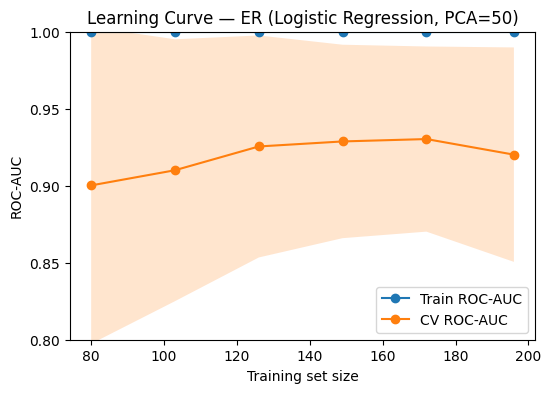

In [17]:
#learning curve LogReg PCA50, dim red standard dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = models["LogReg"]

n_max = min(len(train_idx) for train_idx, _ in cv.split(X_train, y_train))

min_required = int(np.ceil(N_COMPONENTS / (1 - 1/cv.n_splits)))
start = max(min_required, 80)
stop = n_max

train_sizes_abs = np.linspace(start, stop, 6, dtype=int)

train_sizes, train_scores, val_scores = learning_curve(
    pipe_lr,
    X_train,
    y_train,
    cv=cv,
    scoring="roc_auc",
    train_sizes=train_sizes_abs,
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)
train_std  = train_scores.std(axis=1, ddof=1)
val_std    = val_scores.std(axis=1, ddof=1)

plt.figure(figsize=(6, 4))  # <- WICHTIG: wie beim Full-Plot
plt.plot(train_sizes, train_mean, marker="o", label="Train ROC-AUC")
plt.plot(train_sizes, val_mean,   marker="o", label="CV ROC-AUC")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.fill_between(train_sizes, val_mean-val_std,     val_mean+val_std,     alpha=0.2)
plt.xlabel("Training set size")
plt.ylabel("ROC-AUC")
plt.title("Learning Curve — ER (Logistic Regression, PCA=50)")
plt.legend()

plt.ylim(0.8, 1.0)  # <- WICHTIG: gleiche y-Skala
plt.yticks(np.arange(0.8, 1.01, 0.05))  # <- gleiche ticks

plt.savefig("learning curve dimred.jpeg", dpi=300, bbox_inches="tight")
plt.show()


In [18]:
pipe_lr.named_steps["pre"].named_steps["pca"].n_components
#auch rerun

50

n_components has to be ≤ min(n_samples, n_features). 

#### ***universal for different targets***

In [19]:
#universal evaluation function!
def eval_one_target_universal(df_merged, gene_cols, target, task,
                              random_state=42, n_components=50, best_k=11, test_size=0.2):

    X_train, X_test, y_train, y_test, split_idx = make_split_for_target(
        df_merged=df_merged,
        gene_cols=gene_cols,
        target=target,
        task=task,
        test_size=test_size,
        random_state=random_state
    )

    models, scoring, cv = build_eval_models(
        task=task,
        random_state=random_state,
        n_components=n_components,
        best_k=best_k
    )

    rows = []

    for model_name, pipe in models.items():
        for metric, scorer in scoring.items():
            scores = cross_val_score(
                pipe,
                X_train,
                y_train,
                cv=cv,
                scoring=scorer,
                n_jobs=-1
            )
            rows.append({
                "target": target,
                "task": task,
                "model": model_name,
                "split": "cv_train",
                "metric": metric,
                "mean": scores.mean(),
                "std": scores.std(ddof=1),
            })

    for model_name, pipe in models.items():
        pipe.fit(X_train, y_train)

        if task == "binary":
            y_pred = pipe.predict(X_test)
            y_proba = pipe.predict_proba(X_test)[:, 1]
            test_metrics = {
                "roc_auc": roc_auc_score(y_test, y_proba),
                "balanced_acc": balanced_accuracy_score(y_test, y_pred),
                "f1": f1_score(y_test, y_pred, zero_division=0),
                "recall_0": recall_score(y_test, y_pred, pos_label=0),
                "recall_1": recall_score(y_test, y_pred, pos_label=1),
            }

        elif task == "multiclass":
            y_pred = pipe.predict(X_test)
            test_metrics = {
                "balanced_acc": balanced_accuracy_score(y_test, y_pred),
                "macro_f1": f1_score(y_test, y_pred, average="macro", zero_division=0),
                "accuracy": accuracy_score(y_test, y_pred),
            }

        else:  
            y_pred = pipe.predict(X_test)
            test_metrics = {
                "mae": mean_absolute_error(y_test, y_pred),
                "rmse": np.sqrt(mean_squared_error(y_test, y_pred)),
                "r2": r2_score(y_test, y_pred),
            }

        for metric, value in test_metrics.items():
            rows.append({
                "target": target,
                "task": task,
                "model": model_name,
                "split": "test",
                "metric": metric,
                "mean": float(value),
                "std": np.nan,
            })

    return pd.DataFrame(rows)


In [20]:
target_specs = {
    "er": "binary",
    "relapse": "binary",
    "node": "binary",
    "grade": "multiclass",
    "size": "regression"
}

all_results = []

for target, task in target_specs.items():
    print(f"Running evaluation for {target} ({task})")
    df_res = eval_one_target_universal(
        df_merged=df,
        gene_cols=gene_cols,
        target=target,
        task=task,
        random_state=RANDOM_STATE,
        n_components=N_COMPONENTS,
        best_k=best_k,
        test_size=0.2
    )
    all_results.append(df_res)

df_part4 = pd.concat(all_results, ignore_index=True)
df_part4.head(20)


Running evaluation for er (binary)
Running evaluation for relapse (binary)
Running evaluation for node (binary)
Running evaluation for grade (multiclass)
Running evaluation for size (regression)


,target,task,model,split,metric,mean,std
0,er,binary,LogReg,cv_train,roc_auc,0.926983,0.066853
1,er,binary,LogReg,cv_train,avg_precision,0.986093,0.013100
2,er,binary,LogReg,cv_train,balanced_acc,0.776016,0.165535
3,er,binary,LogReg,cv_train,f1,0.941499,0.035289
4,er,binary,RF,cv_train,roc_auc,0.931446,0.065261
5,er,binary,RF,cv_train,avg_precision,0.985607,0.014526
6,er,binary,RF,cv_train,balanced_acc,0.541071,0.037670
7,er,binary,RF,cv_train,f1,0.924786,0.009205
8,er,binary,kNN(k=11),cv_train,roc_auc,0.903827,0.117416
9,er,binary,kNN(k=11),cv_train,avg_precision,0.972130,0.037749


In [21]:
binary_test = df_part4[
    (df_part4["task"]=="binary") &
    (df_part4["split"]=="test") &
    (df_part4["metric"].isin(["roc_auc","balanced_acc","recall_0","recall_1"]))
]

binary_test_summary = binary_test.pivot_table(
    index=["target","model"],
    columns="metric",
    values="mean",
    aggfunc="first"
).round(3)

binary_test_summary


metric                        balanced_acc  recall_0  recall_1  roc_auc
target  model                                                          
er      Dummy(most_frequent)         0.500     0.000     1.000    0.500
        LogReg                       0.833     0.667     1.000    0.964
        RF                           0.667     0.333     1.000    0.952
        kNN(k=11)                    0.722     0.444     1.000    0.948
node    Dummy(most_frequent)         0.500     1.000     0.000    0.500
        LogReg                       0.592     0.821     0.364    0.695
        RF                           0.500     1.000     0.000    0.793
        kNN(k=11)                    0.500     1.000     0.000    0.716
relapse Dummy(most_frequent)         0.500     1.000     0.000    0.500
        LogReg                       0.637     0.885     0.389    0.692
        RF                           0.534     0.846     0.222    0.578
        kNN(k=11)                    0.545     0.923     0.167    0.613

In [22]:
#accuracy, bal accurancy, f1 macro
grade_test_summary = df_part4[
    (df_part4["target"]=="grade") &
    (df_part4["split"]=="test")
].pivot_table(
    index="model",
    columns="metric",
    values="mean",
    aggfunc="first"
).round(3)

grade_test_summary


metric,accuracy,balanced_acc,macro_f1
model,,,
Dummy(most_frequent),0.509,0.333,0.225
LogReg,0.655,0.673,0.655
RF,0.618,0.535,0.556
kNN(k=11),0.545,0.484,0.492


In [23]:
#r^2 and rmse
size_test_summary = df_part4[
    (df_part4["target"]=="size") &
    (df_part4["split"]=="test")
].pivot_table(
    index="model",
    columns="metric",
    values="mean",
    aggfunc="first"
).round(3)

size_test_summary


metric,mae,r2,rmse
model,,,
Dummy(mean),0.676,-0.111,0.854
RFReg,0.605,0.034,0.796
Ridge,0.701,-0.174,0.877


brier und calibration

In [28]:
import numpy as np
import pandas as pd
from sklearn.metrics import brier_score_loss

def _get_proba(pipe, X):
    """Return probabilities for positive class; fallback to sigmoid(decision_function) if needed."""
    if hasattr(pipe, "predict_proba"):
        return pipe.predict_proba(X)[:, 1]
    if hasattr(pipe, "decision_function"):
        s = pipe.decision_function(X)
        return 1 / (1 + np.exp(-s))
    raise ValueError("Model provides neither predict_proba nor decision_function.")

brier_rows = []

for target in ["er", "node", "relapse"]:
    X_train, X_test, y_train, y_test, split_idx = make_split_for_target(
        df_merged=df,
        gene_cols=gene_cols,
        target=target,
        task="binary",
        test_size=0.2,
        random_state=RANDOM_STATE
    )

    models, scoring, cv = build_eval_models(
        task="binary",
        random_state=RANDOM_STATE,
        n_components=N_COMPONENTS,
        best_k=best_k
    )

    for model_name, pipe in models.items():
        pipe.fit(X_train, y_train)

        y_proba = _get_proba(pipe, X_test)

        brier_rows.append({
            "target": target,
            "model": model_name,
            "brier": float(brier_score_loss(y_test, y_proba)),
            "N_test": int(len(y_test)),
            "pos_rate_test": float(np.mean(y_test))
        })

df_brier_pca = pd.DataFrame(brier_rows).sort_values(["target", "model"]).reset_index(drop=True)
df_brier_pca.round(4)


,target,model,brier,N_test,pos_rate_test
0,er,Dummy(most_frequent),0.1452,62,0.8548
1,er,LogReg,0.0485,62,0.8548
2,er,RF,0.0623,62,0.8548
3,er,kNN(k=11),0.0621,62,0.8548
4,node,Dummy(most_frequent),0.2200,50,0.2200
5,node,LogReg,0.2342,50,0.2200
6,node,RF,0.1480,50,0.2200
7,node,kNN(k=11),0.1572,50,0.2200
8,relapse,Dummy(most_frequent),0.4091,44,0.4091
9,relapse,LogReg,0.2138,44,0.4091


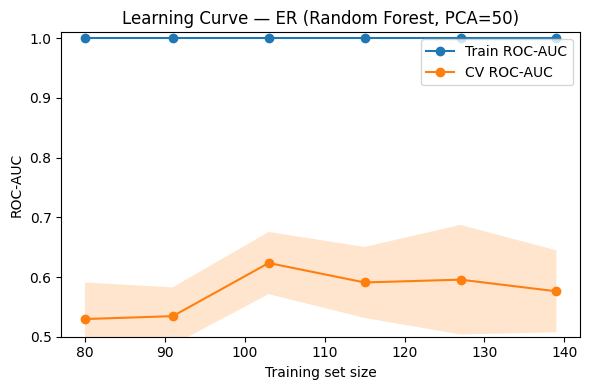

In [25]:
#learning curve RF 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, StratifiedKFold

models, scoring, cv = build_eval_models(
    task="binary",
    random_state=RANDOM_STATE,
    n_components=50,
    best_k=best_k
)

pipe_rf = models["RF"]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

n_max = min(len(train_idx) for train_idx, _ in cv.split(X_train, y_train))

start = 80
stop = n_max
if start >= stop:
    start = max(10, stop - 1)

train_sizes_abs = np.linspace(start, stop, 6, dtype=int)

train_sizes, train_scores, val_scores = learning_curve(
    pipe_rf,
    X_train,
    y_train,
    cv=cv,
    scoring="roc_auc",
    train_sizes=train_sizes_abs,
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)
train_std  = train_scores.std(axis=1, ddof=1)
val_std    = val_scores.std(axis=1, ddof=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_mean, marker="o", label="Train ROC-AUC")
plt.plot(train_sizes, val_mean, marker="o", label="CV ROC-AUC")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.2)

plt.xlabel("Training set size")
plt.ylabel("ROC-AUC")
plt.title("Learning Curve — ER (Random Forest, PCA=50)")
plt.legend()

plt.ylim(0.5, 1.01)            
plt.yticks(np.arange(0.5, 1.01, 0.1))

plt.tight_layout()
plt.savefig("learning curve dimred_rf.jpeg", dpi=300, bbox_inches="tight")
plt.show()


In [26]:
print("train_sizes:", train_sizes)
print("train_scores shape:", train_scores.shape)
print("val_scores shape:", val_scores.shape)

print("train_mean:", train_scores.mean(axis=1))
print("val_mean  :", val_scores.mean(axis=1))

print("train_std :", train_scores.std(axis=1))
print("val_std   :", val_scores.std(axis=1))

print("Any NaN in val_scores?", np.isnan(val_scores).any())
print("Unique val_means:", np.unique(np.round(val_scores.mean(axis=1), 6)))


train_sizes: [ 80  91 103 115 127 139]
train_scores shape: (6, 5)
val_scores shape: (6, 5)
train_mean: [1. 1. 1. 1. 1. 1.]
val_mean  : [0.52961565 0.53446939 0.6235034  0.59091497 0.59562245 0.57608844]
train_std : [4.96506831e-17 4.96506831e-17 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.96506831e-17]
val_std   : [0.05479217 0.04320711 0.04655858 0.05320359 0.08209534 0.06135902]
Any NaN in val_scores? False
Unique val_means: [0.529616 0.534469 0.576088 0.590915 0.595622 0.623503]


Using: kNN(k=11)
Train mean: [1. 1. 1. 1. 1. 1.]
CV mean   : [0.58484354 0.54431293 0.59293197 0.58454422 0.58544218 0.58479592]


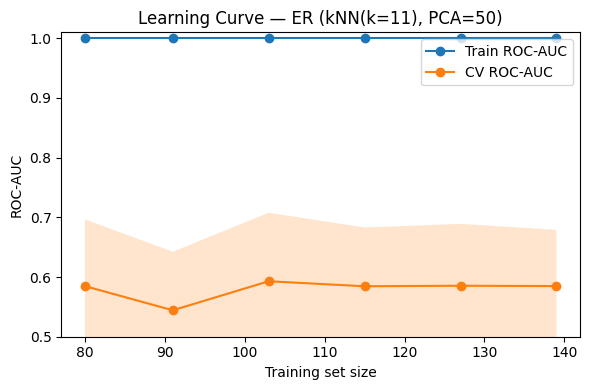

In [27]:
#learning courve kNN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, StratifiedKFold

models, scoring, cv = build_eval_models(
    task="binary",
    random_state=RANDOM_STATE,
    n_components=50,
    best_k=best_k
)

knn_key = [k for k in models.keys() if k.startswith("kNN")][0]
pipe_knn = models[knn_key]
print("Using:", knn_key)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

n_max = min(len(train_idx) for train_idx, _ in cv.split(X_train, y_train))
start, stop = 80, n_max
if start >= stop:
    start = max(10, stop - 1)

train_sizes_abs = np.linspace(start, stop, 6, dtype=int)

train_sizes, train_scores, val_scores = learning_curve(
    pipe_knn, X_train, y_train,
    cv=cv, scoring="roc_auc",
    train_sizes=train_sizes_abs,
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)
train_std  = train_scores.std(axis=1, ddof=1)
val_std    = val_scores.std(axis=1, ddof=1)

print("Train mean:", train_mean)
print("CV mean   :", val_mean)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_mean, marker="o", label="Train ROC-AUC")
plt.plot(train_sizes, val_mean, marker="o", label="CV ROC-AUC")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.2)

plt.xlabel("Training set size")
plt.ylabel("ROC-AUC")
plt.title(f"Learning Curve — ER ({knn_key}, PCA=50)")
plt.legend()

plt.ylim(0.5, 1.01)            
plt.yticks(np.arange(0.5, 1.01, 0.1))

plt.tight_layout()
plt.savefig("learning curve dimred_rf.jpeg", dpi=300, bbox_inches="tight")
plt.show()
